<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/feature_engineering/TX_Labeling_CDC_Guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

* This colab is for labeling CA data from combined datasets and maryland intertia dataset following CDC guideline 



In [2]:
# Task 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install wget
import wget

In [4]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan14.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan14.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CombinedData_Labeled_CDCGuideline_Jan15.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.csv


### Location

In [5]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

# Load Combined Dataset

## Data Preprocessing

In [8]:
TX_combined_data = pd.read_csv(location+'TX_alldatasets_Jan11.csv',low_memory=False)
TX_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,Texas,48001,0,Anderson County,57735,0,8.910,79,16.0,15.0,0.0,0.0,3.0,0.0
1,2020-03-02,Texas,48001,0,Anderson County,57735,0,10.708,95,14.0,7.0,0.0,0.0,2.0,-1.0
2,2020-03-03,Texas,48001,0,Anderson County,57735,0,12.118,107,21.0,8.0,0.0,0.0,2.0,-2.0
3,2020-03-04,Texas,48001,0,Anderson County,57735,0,9.156,81,12.0,5.0,0.0,0.0,1.0,2.0
4,2020-03-05,Texas,48001,0,Anderson County,57735,0,11.230,100,18.0,13.0,0.0,0.0,3.0,-3.0


## 'New Cases/100k population'

In [9]:
TX_combined_data['New Cases/100k population'] = TX_combined_data['New cases']*100000/ TX_combined_data['population']
TX_combined_data.tail(2)

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population
53461,2021-01-04,Texas,48507,0,Zavala County,11840,1,10.211,106,0.0,0.0,0.0,0.0,-32.0,0.0,0.000000
53462,2021-01-05,Texas,48507,98,Zavala County,11840,1,1.758,18,0.0,0.0,0.0,0.0,-31.0,0.0,827.702703


## Computing rolling average

In [10]:
TX_combined_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population'],
      dtype='object')

In [11]:
col_idx = TX_combined_data.columns.get_loc("New Cases/100k population")
print(col_idx)

15


15 no column  = New Cases/100k population

In [12]:
TX_combined_data.iloc[:,col_idx]

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
53458     84.459459
53459     42.229730
53460      0.000000
53461      0.000000
53462    827.702703
Name: New Cases/100k population, Length: 53463, dtype: float64

### Filter CA

In [13]:
TX_combined_data = TX_combined_data.loc[TX_combined_data['Province_State'] == 'Texas']
TX_combined_data.reset_index(drop=True)

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population
0,2020-03-01,Texas,48001,0,Anderson County,57735,0,8.910,79,16.0,15.0,0.0,0.0,3.0,0.0,0.000000
1,2020-03-02,Texas,48001,0,Anderson County,57735,0,10.708,95,14.0,7.0,0.0,0.0,2.0,-1.0,0.000000
2,2020-03-03,Texas,48001,0,Anderson County,57735,0,12.118,107,21.0,8.0,0.0,0.0,2.0,-2.0,0.000000
3,2020-03-04,Texas,48001,0,Anderson County,57735,0,9.156,81,12.0,5.0,0.0,0.0,1.0,2.0,0.000000
4,2020-03-05,Texas,48001,0,Anderson County,57735,0,11.230,100,18.0,13.0,0.0,0.0,3.0,-3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53458,2020-12-30,Texas,48507,10,Zavala County,11840,1,4.564,47,0.0,0.0,0.0,0.0,-38.0,0.0,84.459459
53459,2020-12-31,Texas,48507,5,Zavala County,11840,1,3.274,34,0.0,0.0,0.0,0.0,-44.0,0.0,42.229730
53460,2021-01-01,Texas,48507,0,Zavala County,11840,1,1.683,17,0.0,0.0,0.0,0.0,-61.0,0.0,0.000000
53461,2021-01-04,Texas,48507,0,Zavala County,11840,1,10.211,106,0.0,0.0,0.0,0.0,-32.0,0.0,0.000000


In [14]:
TX_combined_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population'],
      dtype='object')

old

['Date', 'Province_State', 'FIPS','County Name','population',
                           'retail and recreation','grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'New Cases/100k population', 'countyFIPS', 'State',
       'county_population','rolling_avg_new_cases/100k']

In [15]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS','County Name','population',
                           'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population','rolling_avg_new_cases/100k'])


In [16]:
col_idx = TX_combined_data.columns.get_loc("New Cases/100k population")
print(col_idx)

15


In [17]:
CA_counties = TX_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = TX_combined_data[TX_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,col_idx].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,Texas,48001,Anderson County,57735,0,8.910,79,16.0,15.0,0.0,0.0,3.0,0.0,0.0,NaN,0.0
1,2020-03-02,Texas,48001,Anderson County,57735,0,10.708,95,14.0,7.0,0.0,0.0,2.0,-1.0,0.0,NaN,0.0
2,2020-03-03,Texas,48001,Anderson County,57735,0,12.118,107,21.0,8.0,0.0,0.0,2.0,-2.0,0.0,NaN,0.0
3,2020-03-04,Texas,48001,Anderson County,57735,0,9.156,81,12.0,5.0,0.0,0.0,1.0,2.0,0.0,NaN,0.0
4,2020-03-05,Texas,48001,Anderson County,57735,0,11.230,100,18.0,13.0,0.0,0.0,3.0,-3.0,0.0,NaN,0.0


In [18]:
print(df.shape)
TX_combined_data.shape

(53463, 17)


(53463, 16)

In [19]:
TX_combined_data = df.copy()
TX_combined_data

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,Texas,48001,Anderson County,57735,0,8.910,79,16.0,15.0,0.0,0.0,3.0,0.0,0.000000,NaN,0.0
1,2020-03-02,Texas,48001,Anderson County,57735,0,10.708,95,14.0,7.0,0.0,0.0,2.0,-1.0,0.000000,NaN,0.0
2,2020-03-03,Texas,48001,Anderson County,57735,0,12.118,107,21.0,8.0,0.0,0.0,2.0,-2.0,0.000000,NaN,0.0
3,2020-03-04,Texas,48001,Anderson County,57735,0,9.156,81,12.0,5.0,0.0,0.0,1.0,2.0,0.000000,NaN,0.0
4,2020-03-05,Texas,48001,Anderson County,57735,0,11.230,100,18.0,13.0,0.0,0.0,3.0,-3.0,0.000000,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53458,2020-12-30,Texas,48507,Zavala County,11840,1,4.564,47,0.0,0.0,0.0,0.0,-38.0,0.0,84.459459,59.121622,10.0
53459,2020-12-31,Texas,48507,Zavala County,11840,1,3.274,34,0.0,0.0,0.0,0.0,-44.0,0.0,42.229730,61.534749,5.0
53460,2021-01-01,Texas,48507,Zavala County,11840,1,1.683,17,0.0,0.0,0.0,0.0,-61.0,0.0,0.000000,22.924710,0.0
53461,2021-01-04,Texas,48507,Zavala County,11840,1,10.211,106,0.0,0.0,0.0,0.0,-32.0,0.0,0.000000,22.924710,0.0


In [20]:
TX_combined_data[TX_combined_data['Date'] == '2020-08-01'].head(4)

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
151,2020-08-01,Texas,48001,Anderson County,57735,1,7.538,67,-6.0,5.0,0.0,0.0,-6.0,0.0,22.516671,17.073080,13.0
445,2020-08-01,Texas,48003,Andrews County,18705,1,2.809,60,0.0,0.0,0.0,-22.0,-25.0,0.0,0.000000,22.912132,0.0
720,2020-08-01,Texas,48005,Angelina County,86715,1,7.438,76,-15.0,5.0,-3.0,-2.0,-14.0,4.0,47.281324,39.867876,41.0
1020,2020-08-01,Texas,48007,Aransas County,23510,1,5.184,108,13.0,16.0,44.0,0.0,-15.0,0.0,0.000000,18.229325,0.0


## clean data - fill NA 

In [21]:
TX_combined_data = TX_combined_data.fillna(0)
TX_combined_data.head(8)

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,Texas,48001,Anderson County,57735,0,8.910,79,16.0,15.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,2020-03-02,Texas,48001,Anderson County,57735,0,10.708,95,14.0,7.0,0.0,0.0,2.0,-1.0,0.0,0.0,0.0
2,2020-03-03,Texas,48001,Anderson County,57735,0,12.118,107,21.0,8.0,0.0,0.0,2.0,-2.0,0.0,0.0,0.0
3,2020-03-04,Texas,48001,Anderson County,57735,0,9.156,81,12.0,5.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
4,2020-03-05,Texas,48001,Anderson County,57735,0,11.230,100,18.0,13.0,0.0,0.0,3.0,-3.0,0.0,0.0,0.0
5,2020-03-06,Texas,48001,Anderson County,57735,0,13.757,122,8.0,10.0,0.0,0.0,3.0,-1.0,0.0,0.0,0.0
6,2020-03-07,Texas,48001,Anderson County,57735,0,11.261,100,9.0,12.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
7,2020-03-08,Texas,48001,Anderson County,57735,0,9.883,88,13.0,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Labeling: Apply CDC Guideline for all counties

https://edsource.org/2020/quick-guide-what-californias-color-coded-county-tracking-system-means-for-schools/639357

In [22]:
county_names = TX_combined_data['County Name'].unique()

In [23]:
county_names

array(['Anderson County', 'Andrews County', 'Angelina County',
       'Aransas County', 'Archer County', 'Atascosa County',
       'Austin County', 'Bailey County', 'Bandera County',
       'Bastrop County', 'Bee County', 'Bell County', 'Bexar County',
       'Blanco County', 'Bosque County', 'Bowie County',
       'Brazoria County', 'Brazos County', 'Brewster County',
       'Brooks County', 'Brown County', 'Burleson County',
       'Burnet County', 'Caldwell County', 'Calhoun County',
       'Callahan County', 'Cameron County', 'Camp County',
       'Carson County', 'Cass County', 'Castro County', 'Chambers County',
       'Cherokee County', 'Childress County', 'Clay County',
       'Coleman County', 'Collin County', 'Colorado County',
       'Comal County', 'Comanche County', 'Cooke County',
       'Coryell County', 'Crane County', 'Crockett County',
       'Culberson County', 'Dallam County', 'Dallas County',
       'Dawson County', 'Deaf Smith County', 'Delta County',
       'Dent

In [24]:
TX_combined_data[TX_combined_data['County Name']== 'Anderson County'].population.unique()[0]

57735

In [25]:
TX_combined_data[TX_combined_data['population'] < 300000]['County Name'].shape

(48063,)

* Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
* Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
* Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
* Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity

In [26]:
for county in county_names:
    print('county name: ',county)
    county_population = TX_combined_data[TX_combined_data['County Name']== county].population.unique()[0]
    county_data = TX_combined_data[TX_combined_data['County Name']== county]
    new_cases_100k_la_list = county_data['New Cases/100k population'].values
    #rolling_avg_new_cases/100k_list = county_data['rolling_avg_new_cases/100k'].values
    

    diffArr = np.diff(new_cases_100k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

#implementing cdc guideline-CA color code
#Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
#Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
#Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
#Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity
    for index, row in (county_data.iterrows()):
      i = row['rolling_avg_new_cases/100k']
      if i > 7 :
        label = 'widespread'
      elif (i <= 7) and (i >= 4):
        label = 'substantial'
      elif (i < 4) and (i >= 1):
        label = 'moderate'
      elif i < 1 :
        label = 'minimal'
          
    
      date = row['Date']
      #print(i,county, date, label)

      df_index = (TX_combined_data['County Name'] == county) & (TX_combined_data['Date'] == date) 
      #print(df_weekData)
      TX_combined_data.loc[df_index,'growth_label'] = label
    #break

county name:  Anderson County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


county name:  Andrews County
county name:  Angelina County
county name:  Aransas County
county name:  Archer County
county name:  Atascosa County
county name:  Austin County
county name:  Bailey County
county name:  Bandera County
county name:  Bastrop County
county name:  Bee County
county name:  Bell County
county name:  Bexar County
county name:  Blanco County
county name:  Bosque County
county name:  Bowie County
county name:  Brazoria County
county name:  Brazos County
county name:  Brewster County
county name:  Brooks County
county name:  Brown County
county name:  Burleson County
county name:  Burnet County
county name:  Caldwell County
county name:  Calhoun County
county name:  Callahan County
county name:  Cameron County
county name:  Camp County
county name:  Carson County
county name:  Cass County
county name:  Castro County
county name:  Chambers County
county name:  Cherokee County
county name:  Childress County
county name:  Clay County
county name:  Coleman County
county

In [27]:
print(TX_combined_data[TX_combined_data['growth_label'] == 'widespread'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'substantial'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'moderate'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'minimal'].shape)


(28860, 18)
(4186, 18)
(7721, 18)
(12696, 18)


In [28]:
#to show all rows
pd.set_option('display.max_rows', None)

In [29]:
TX_combined_data.groupby(['County Name','growth_label']).size().reset_index(name='row_count').sort_values(by=['County Name','growth_label','row_count'], ascending=False)

,County Name,growth_label,row_count
799,Zavala County,widespread,115
798,Zavala County,substantial,6
797,Zavala County,moderate,22
796,Zavala County,minimal,62
795,Zapata County,widespread,98
794,Zapata County,substantial,13
793,Zapata County,moderate,37
792,Zapata County,minimal,57
791,Young County,widespread,158
790,Young County,substantial,10


## Verifying with plot

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


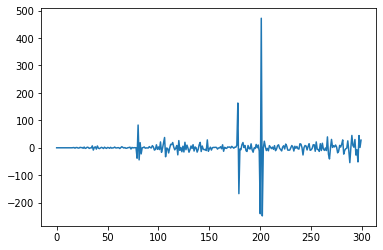

(206, 19)


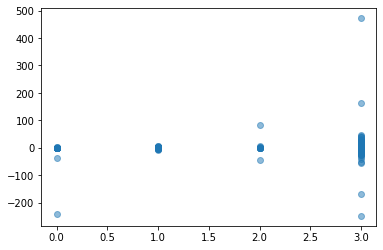

In [30]:
alameda_data = TX_combined_data[TX_combined_data['County Name'] == 'Brazos County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


Using rolling_avg_new_cases/100k

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


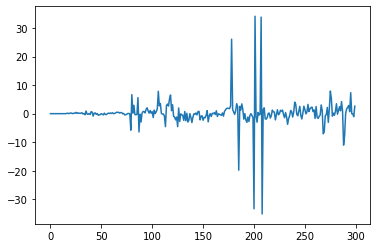

(206, 19)


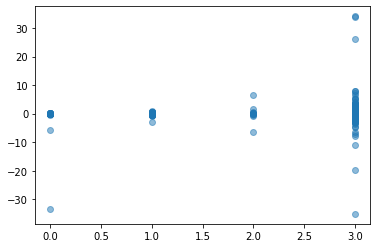

In [31]:
alameda_data = TX_combined_data[TX_combined_data['County Name'] == 'Brazos County']

rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
diffArr = np.diff(rollavg_new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()

## verifying Rolling average with visualizations -Los Angeles County

http://dashboard.publichealth.lacounty.gov/covid19_surveillance_dashboard/

In [32]:
TX_combined_data.Date.unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-

In [33]:
date_list_aug = ['2020-08-01',
       '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
       '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
       '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21']

date_list = ['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
       '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
       '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
       '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
       '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
       '2020-07-29', '2020-07-30', '2020-07-31']

### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [34]:
TX_combined_data[(TX_combined_data['County Name'] == 'Brazos County') & (TX_combined_data['growth_label'] == 'widespread')]['Date'].unique()

array(['2020-05-23', '2020-05-24', '2020-05-27', '2020-06-06',
       '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
       '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
       '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
       '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22',
       '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26',
       '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30',
       '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
       '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
       '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
       '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
       '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
       '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
       '2020-08-02', '2020-08-03', '2020-08-04', '2020-

substantial

In [35]:
TX_combined_data[(TX_combined_data['County Name'] == 'Brazos County') & (TX_combined_data['growth_label'] == 'substantial')]['Date'].unique()

array(['2020-05-11', '2020-05-12', '2020-05-13', '2020-05-21',
       '2020-05-22', '2020-05-25', '2020-05-26', '2020-05-28',
       '2020-05-30', '2020-06-03', '2020-06-04', '2020-06-05',
       '2020-08-20'], dtype=object)

moderate

In [36]:
TX_combined_data[(TX_combined_data['County Name'] == 'Brazos County') & (TX_combined_data['growth_label'] == 'moderate')]['Date'].unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
       '2020-05-09', '2020-05-10', '2020-05-14', '2020-05-15',
       '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19',
       '2020-05-31', '2020-06-01', '2020-06-02'], dtype=object)

minimal

In [37]:
TX_combined_data[(TX_combined_data['County Name'] == 'Brazos County') & (TX_combined_data['growth_label'] == 'minimal')]['Date'].unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
       '2020-05-20', '2020-09-19'], dtype=object)

### Other

In [38]:
los_angeles_county = TX_combined_data[(TX_combined_data['County Name'] == 'Brazos County') & TX_combined_data['Date'].isin(date_list)]
print(los_angeles_county.shape)
los_angeles_county.head()

(31, 18)


,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases,growth_label
4780,2020-07-01,Texas,48041,Brazos County,229211,0,5.688,116,-20.0,-4.0,14.0,-36.0,-42.0,14.0,53.226067,46.744204,122.0,widespread
4781,2020-07-02,Texas,48041,Brazos County,229211,0,6.002,122,-21.0,-2.0,15.0,-44.0,-44.0,14.0,44.064203,45.809320,101.0,widespread
4782,2020-07-03,Texas,48041,Brazos County,229211,1,6.379,130,-24.0,2.0,-6.0,-43.0,-58.0,19.0,44.936761,44.625133,103.0,widespread
4783,2020-07-04,Texas,48041,Brazos County,229211,1,5.300,108,-44.0,-18.0,-2.0,-44.0,-31.0,6.0,30.539547,42.443737,70.0,widespread
4784,2020-07-05,Texas,48041,Brazos County,229211,1,3.980,81,-38.0,-24.0,-26.0,-48.0,-24.0,7.0,36.211177,41.259551,83.0,widespread


In [39]:
los_angeles_county.growth_label.unique()

array(['widespread'], dtype=object)

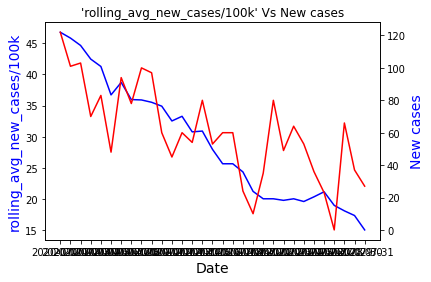

In [40]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")
plt.xticks(rotation=90)
plt.show()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 <a list of 31 Text major ticklabel objects>)

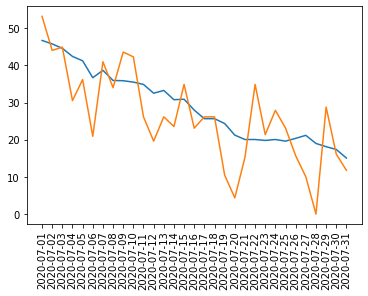

In [41]:
x = los_angeles_county['Date']
y1 = los_angeles_county['rolling_avg_new_cases/100k'] 
y2 = los_angeles_county['New Cases/100k population']


plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


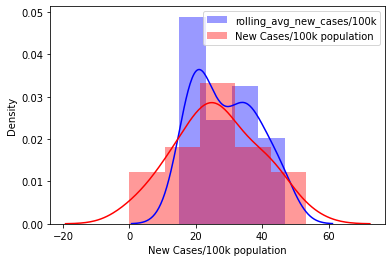

In [42]:
sns.distplot( (los_angeles_county['rolling_avg_new_cases/100k'] ) , color="blue", label='rolling_avg_new_cases/100k')
sns.distplot( los_angeles_county['New Cases/100k population'] , color="red", label='New Cases/100k population')
plt.legend()
 
plt.show()

## Angelina County

https://rivcoph.org/coronavirus

In [43]:
suffolk_county = TX_combined_data[TX_combined_data['County Name'] == 'Angelina County']

### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [44]:
TX_combined_data[(TX_combined_data['County Name'] == 'Angelina County') & (TX_combined_data['growth_label'] == 'widespread')]['Date'].unique()

array(['2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11',
       '2020-05-21', '2020-06-03', '2020-06-10', '2020-06-11',
       '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
       '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
       '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23',
       '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27',
       '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01',
       '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05',
       '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
       '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
       '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
       '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
       '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
       '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
       '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02',
       '2020-08-03', '2020-08-04', '2020-08-05', '2020-

substantial

In [45]:
TX_combined_data[(TX_combined_data['County Name'] == 'Angelina County') & (TX_combined_data['growth_label'] == 'substantial')]['Date'].unique()

array(['2020-05-05', '2020-05-06', '2020-05-07', '2020-05-12',
       '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
       '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
       '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
       '2020-05-27', '2020-05-28', '2020-05-30', '2020-05-31',
       '2020-06-01', '2020-06-02', '2020-06-04', '2020-06-05',
       '2020-06-06', '2020-06-07', '2020-06-08', '2020-08-25',
       '2020-08-26', '2020-08-30', '2020-08-31', '2020-09-09',
       '2020-09-10', '2020-09-16', '2020-09-18', '2020-09-19',
       '2020-09-20', '2020-09-21', '2020-09-24', '2020-09-25',
       '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
       '2020-10-07', '2020-10-09', '2020-10-10', '2020-10-11',
       '2020-10-12', '2020-10-13', '2020-10-17', '2020-10-18',
       '2020-10-19', '2020-10-20', '2020-10-23', '2020-10-24',
       '2020-10-25', '2020-10-26', '2020-10-28', '2020-10-29',
       '2020-10-30', '2020-10-31'], dtype=object)

moderate

In [46]:
TX_combined_data[(TX_combined_data['County Name'] == 'Angelina County') & (TX_combined_data['growth_label'] == 'moderate')]['Date'].unique()

array(['2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-26', '2020-06-09', '2020-08-27', '2020-09-04',
       '2020-09-05', '2020-09-06', '2020-09-07', '2020-10-14',
       '2020-10-15'], dtype=object)

minimal

In [47]:
TX_combined_data[(TX_combined_data['County Name'] == 'Angelina County') & (TX_combined_data['growth_label'] == 'minimal')]['Date'].unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-11', '2020-04-12',
       '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
       '2020-09-08'], dtype=object)

### Other

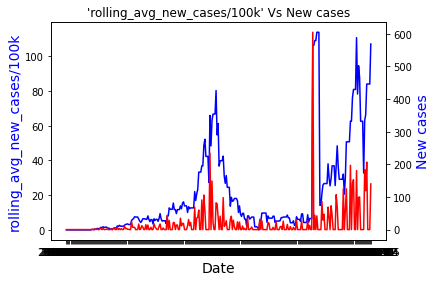

In [48]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")

plt.show()

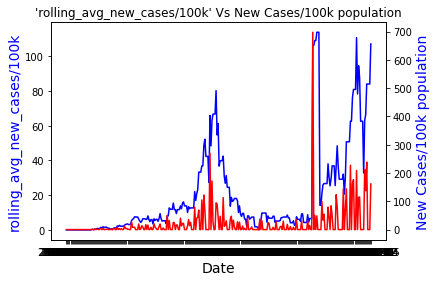

In [49]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New Cases/100k population"],color="red")
ax2.set_ylabel("New Cases/100k population",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New Cases/100k population")

plt.show()

## Export to CSV file to drive

In [50]:
print(TX_combined_data[TX_combined_data['growth_label'] == 'widespread'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'substantial'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'moderate'].shape)
print(TX_combined_data[TX_combined_data['growth_label'] == 'minimal'].shape)

(28860, 18)
(4186, 18)
(7721, 18)
(12696, 18)


In [51]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'TX_CombinedData_Labeled_CDCGuideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
TX_combined_data.to_csv(location+filename,index=False)

TX_CombinedData_Labeled_CDCGuideline_Jan15.csv


# 2. Loading Maryland Inertia

In [7]:
maryland_sd_inertia = pd.read_csv(location+'TX_processedMarylandData_Jan11.csv',low_memory=False)
maryland_sd_inertia.head()


,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,48001,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
1,48001,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
2,48001,Anderson County,TX,57735,48001,Anderson County,48,10,13,3.65,23.5,0.5,47.7,0.55,3.10,0,58057,4.9,2020-01-03,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
3,48001,Anderson County,TX,57735,48001,Anderson County,48,20,17,3.33,25.5,0.5,46.2,0.40,2.93,0,58057,-0.8,2020-01-04,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
4,48001,Anderson County,TX,57735,48001,Anderson County,48,32,21,2.93,21.4,0.6,42.7,0.36,2.57,0,58057,-13.0,2020-01-05,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,4.6,0.2,0.0


## Fixdate column of Social Distancing inertia

In [8]:
#old columns:

old_columns = ['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
       'COVID death rate']

In [9]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

## Filter Data -CA State

In [10]:
maryland_sd_inertia.head(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,48001,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
1,48001,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0


In [11]:
maryland_sd_inertia.State.unique()

array(['TX'], dtype=object)

## 'New Cases/100k population'

In [12]:
maryland_sd_inertia.head(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,48001,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0
1,48001,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0


In [13]:
maryland_sd_inertia['New Cases/100k population'] = maryland_sd_inertia['New.COVID.cases']*100000/ maryland_sd_inertia['population']
maryland_sd_inertia.tail(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population
92200,48507,Zavala County,TX,11840,48507,Zavala County,48,41,30,2.73,37.9,0.0,44.5,0.43,2.30,0,11983,-22.1,2020-12-27,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.0278,14.54,3,64.044408,12.4,468.83,32.74,1361,142,42.48,273,0.8,9.3,34.5,0.29,2.21,0.0
92201,48507,Zavala County,TX,11840,48507,Zavala County,48,29,22,3.52,28.4,0.2,33.4,0.59,2.92,0,11983,-1.1,2020-12-28,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.0000,14.66,4,64.364907,12.5,470.92,34.03,1390,141,42.48,273,0.8,9.3,34.5,0.29,2.21,0.0


## Computing rolling average

In [14]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [15]:
maryland_sd_inertia.shape

(92202, 48)

In [16]:
col_idx = maryland_sd_inertia.columns.get_loc("New Cases/100k population")
print(col_idx)

47


47 no column  = New Cases/100k population

In [17]:
maryland_sd_inertia.iloc[:,col_idx]

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
92197    0.000000
92198    8.445946
92199    0.000000
92200    0.000000
92201    0.000000
Name: New Cases/100k population, Length: 92202, dtype: float64

In [18]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [19]:
df = pd.DataFrame(columns=['County Name', 'State', 'population', 'CTFIPS', 'CTNAME','STFIPS',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home','Cumulative.inflation.rate',
       'COVID.death.rate', 'New Cases/100k population','rolling_avg_new_cases/100k'])

In [20]:
# for reference; we don't use it
df_old = pd.DataFrame(columns=['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
       'COVID death rate', 'New Cases/100k population','rolling_avg_new_cases/100k'])


In [21]:
CA_counties = maryland_sd_inertia['CTNAME'].unique()

for county in CA_counties:
  county_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,col_idx].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,NaN,48001.0
1,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,NaN,48001.0
2,Anderson County,TX,57735,48001,Anderson County,48,10,13,3.65,23.5,0.5,47.7,0.55,3.10,0,58057,4.9,2020-01-03,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,NaN,48001.0
3,Anderson County,TX,57735,48001,Anderson County,48,20,17,3.33,25.5,0.5,46.2,0.40,2.93,0,58057,-0.8,2020-01-04,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,NaN,48001.0
4,Anderson County,TX,57735,48001,Anderson County,48,32,21,2.93,21.4,0.6,42.7,0.36,2.57,0,58057,-13.0,2020-01-05,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,4.6,0.2,0.0,0.0,NaN,48001.0


In [22]:
print(df.shape)
maryland_sd_inertia.shape

(92202, 49)


(92202, 48)

In [23]:
maryland_sd_inertia = df.copy()
maryland_sd_inertia

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.0000,0.00,0,47.700000,0.0,0.00,0.00,0,0,0.00,0,0.4,3.5,4.6,0.20,0.00,0.000000,NaN,48001.0
1,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.0000,0.00,0,47.700000,0.0,0.00,0.00,0,0,0.00,0,0.4,3.5,4.6,0.20,0.00,0.000000,NaN,48001.0
2,Anderson County,TX,57735,48001,Anderson County,48,10,13,3.65,23.5,0.5,47.7,0.55,3.10,0,58057,4.9,2020-01-03,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.0000,0.00,0,47.700000,0.0,0.00,0.00,0,0,0.00,0,0.4,3.5,4.6,0.20,0.00,0.000000,NaN,48001.0
3,Anderson County,TX,57735,48001,Anderson County,48,20,17,3.33,25.5,0.5,46.2,0.40,2.93,0,58057,-0.8,2020-01-04,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.0000,0.00,0,47.700000,0.0,0.00,0.00,0,0,0.00,0,0.4,3.5,4.6,0.20,0.00,0.000000,NaN,48001.0
4,Anderson County,TX,57735,48001,Anderson County,48,32,21,2.93,21.4,0.6,42.7,0.36,2.57,0,58057,-13.0,2020-01-05,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.0000,0.00,0,47.700000,0.0,0.00,0.00,0,0,0.00,0,0.7,3.5,4.6,0.20,0.00,0.000000,NaN,48001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92197,Zavala County,TX,11840,48507,Zavala County,48,24,20,3.38,34.3,0.1,40.6,0.44,2.94,0,11983,-0.4,2020-12-24,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.9736,14.34,0,63.188298,12.6,457.70,32.84,1285,161,42.89,273,0.8,9.3,34.5,0.29,2.17,0.000000,59.121622,48507.0
92198,Zavala County,TX,11840,48507,Zavala County,48,58,30,2.21,33.9,0.0,22.7,0.44,1.77,1,11983,-40.1,2020-12-25,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.9180,13.93,1,63.455955,12.5,461.66,32.74,1309,111,42.48,273,0.8,9.3,34.5,0.29,2.21,8.445946,49.469112,48507.0
92199,Zavala County,TX,11840,48507,Zavala County,48,45,28,2.97,34.5,0.0,26.0,0.44,2.54,0,11983,-14.0,2020-12-26,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.0278,13.90,2,63.739538,12.4,465.73,32.74,1334,152,42.48,273,0.8,9.3,34.5,0.29,2.21,0.000000,43.436293,48507.0
92200,Zavala County,TX,11840,48507,Zavala County,48,41,30,2.73,37.9,0.0,44.5,0.43,2.30,0,11983,-22.1,2020-12-27,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,0.0278,14.54,3,64.044408,12.4,468.83,32.74,1361,142,42.48,273,0.8,9.3,34.5,0.29,2.21,0.000000,43.436293,48507.0


In [24]:
maryland_sd_inertia[maryland_sd_inertia['date'] == '2020-08-01'].head(4)

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
213,Anderson County,TX,57735,48001,Anderson County,48,22,19,3.46,25.7,0.3,56.7,0.35,3.10,13,58057,4.9,2020-08-01,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,0.2124,9.14,17,51.599003,11.5,130.58,35.73,1008,373,7.66,133,2.2,7.3,42.3,0.39,3.12,22.516671,17.073080,48001.0
576,Andrews County,TX,18705,48003,Andrews County,48,36,26,3.12,30.3,4.6,65.8,0.34,2.77,0,18128,-11.0,2020-08-01,0.00,15,74233,1.8,56.0,51.08,12,4,101,2.82,0.3,0.04,0.3126,9.14,4,51.599003,11.5,130.58,35.73,1008,122,7.66,133,2.2,7.3,42.3,0.39,3.12,0.000000,22.912132,48003.0
939,Angelina County,TX,86715,48005,Angelina County,48,28,24,3.54,23.0,1.0,47.4,0.37,3.17,41,87092,7.1,2020-08-01,0.26,21,47714,14.6,21.9,48.69,101,51,123,2.82,0.3,0.04,0.3100,9.14,2,51.599003,11.5,130.58,35.73,1008,524,7.66,133,2.2,7.3,42.3,0.39,3.12,47.281324,39.867876,48005.0
1302,Aransas County,TX,23510,48007,Aransas County,48,39,31,2.66,50.6,0.8,28.8,0.24,2.42,0,23792,-12.1,2020-08-01,0.00,35,44865,1.5,27.3,48.56,47,14,163,2.82,0.3,0.04,0.2382,9.14,1,51.599003,11.5,130.58,35.73,1008,341,7.66,133,2.2,7.3,42.3,0.39,3.12,0.000000,18.229325,48007.0


## clean data - fill NA 

In [25]:
maryland_sd_inertia = maryland_sd_inertia.fillna(0)
maryland_sd_inertia.head(8)

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.58,20.1,0.4,34.1,0.30,2.28,0,58057,-22.8,2020-01-01,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
1,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.36,21.3,0.3,42.7,0.53,2.82,0,58057,-4.5,2020-01-02,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
2,Anderson County,TX,57735,48001,Anderson County,48,10,13,3.65,23.5,0.5,47.7,0.55,3.10,0,58057,4.9,2020-01-03,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
3,Anderson County,TX,57735,48001,Anderson County,48,20,17,3.33,25.5,0.5,46.2,0.40,2.93,0,58057,-0.8,2020-01-04,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.4,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
4,Anderson County,TX,57735,48001,Anderson County,48,32,21,2.93,21.4,0.6,42.7,0.36,2.57,0,58057,-13.0,2020-01-05,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
5,Anderson County,TX,57735,48001,Anderson County,48,16,15,3.44,19.5,0.2,40.7,0.49,2.94,0,58057,-0.5,2020-01-06,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
6,Anderson County,TX,57735,48001,Anderson County,48,17,14,3.40,19.6,0.3,39.4,0.50,2.90,0,58057,-1.8,2020-01-07,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,7,0.7,3.5,4.6,0.2,0.0,0.0,0.0,48001.0
7,Anderson County,TX,57735,48001,Anderson County,48,14,14,3.44,20.6,0.2,40.6,0.53,2.91,0,58057,-1.5,2020-01-08,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0,0.0,7,0.7,3.5,4.6,0.2,0.0,0.0,0.0,48001.0


## Labeling: Apply CDC Guideline for all counties

https://edsource.org/2020/quick-guide-what-californias-color-coded-county-tracking-system-means-for-schools/639357

In [26]:
county_names = maryland_sd_inertia['CTNAME'].unique()

* Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
* Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
* Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
* Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity

In [27]:
for county in county_names:   
    print('county :',county)
    county_population = maryland_sd_inertia[maryland_sd_inertia['CTNAME']== county].Population.unique()[0]
    county_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME']== county]
    new_cases_100k_la_list = county_data['New Cases/100k population'].values
    diffArr = np.diff(new_cases_100k_la_list)
    


    diffArr = np.diff(new_cases_100k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

#implementing cdc guideline-CA color code
#Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
#Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
#Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
#Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity
    for index, row in (county_data.iterrows()):
      i = row['rolling_avg_new_cases/100k']
      if i > 7 :
        label = 'widespread'
      elif (i <= 7) and (i >= 4):
        label = 'substantial'
      elif (i < 4) and (i >= 1):
        label = 'moderate'
      elif i < 1 :
        label = 'minimal'
          
    
      date = row['date']
      #print(i,county, date, label)

      df_index = (maryland_sd_inertia['CTNAME'] == county) & (maryland_sd_inertia['date'] == date) 
      #print(df_weekData)
      maryland_sd_inertia.loc[df_index,'growth_label'] = label
    #break

county : Anderson County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


county : Andrews County
county : Angelina County
county : Aransas County
county : Archer County
county : Armstrong County
county : Atascosa County
county : Austin County
county : Bailey County
county : Bandera County
county : Bastrop County
county : Baylor County
county : Bee County
county : Bell County
county : Bexar County
county : Blanco County
county : Borden County
county : Bosque County
county : Bowie County
county : Brazoria County
county : Brazos County
county : Brewster County
county : Briscoe County
county : Brooks County
county : Brown County
county : Burleson County
county : Burnet County
county : Caldwell County
county : Calhoun County
county : Callahan County
county : Cameron County
county : Camp County
county : Carson County
county : Cass County
county : Castro County
county : Chambers County
county : Cherokee County
county : Childress County
county : Clay County
county : Cochran County
county : Coke County
county : Coleman County
county : Collin County
county : Collings

In [28]:
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'widespread'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'substantial'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'moderate'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'minimal'].shape)

(39259, 50)
(6491, 50)
(9886, 50)
(36566, 50)


## Verifying the labeling with plot- Los Angeles

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


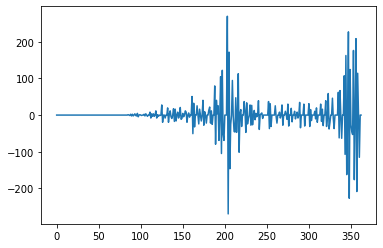

(154, 51)


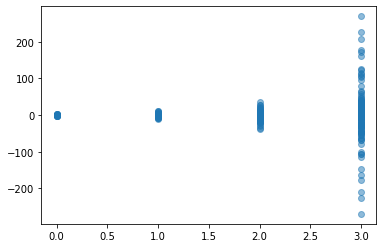

In [29]:
alameda_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'Angelina County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [30]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Angelina County') & (maryland_sd_inertia['growth_label'] == 'widespread')]['date'].unique()

array(['2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11',
       '2020-05-21', '2020-06-10', '2020-06-11', '2020-06-12',
       '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16',
       '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20',
       '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
       '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
       '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02',
       '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
       '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
       '2020-07-11', '2020-07-12', '2020-07-13', '2020-07-14',
       '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18',
       '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22',
       '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
       '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
       '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03',
       '2020-08-04', '2020-08-05', '2020-08-06', '2020-

substantial

In [31]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Angelina County') & (maryland_sd_inertia['growth_label'] == 'substantial')]['date'].unique()

array(['2020-05-05', '2020-05-06', '2020-05-07', '2020-05-12',
       '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
       '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
       '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
       '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
       '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03',
       '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07',
       '2020-06-08', '2020-08-25', '2020-08-26', '2020-08-30',
       '2020-08-31', '2020-09-09', '2020-09-10', '2020-09-16',
       '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21',
       '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27',
       '2020-09-28', '2020-09-29', '2020-10-07', '2020-10-08',
       '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-17',
       '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-23',
       '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-28',
       '2020-10-29', '2020-10-30', '2020-10-31', '2020-

moderate

In [32]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Angelina County') & (maryland_sd_inertia['growth_label'] == 'moderate')]['date'].unique()

array(['2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
       '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
       '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
       '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02',
       '2020-05-03', '2020-05-04', '2020-05-26', '2020-06-09',
       '2020-08-27', '2020-09-04', '2020-09-05', '2020-09-06',
       '2020-09-07', '2020-10-09', '2020-10-13', '2020-10-14',
       '2020-10-15', '2020-11-03', '2020-11-04'], dtype=object)

minimal

In [33]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Angelina County') & (maryland_sd_inertia['growth_label'] == 'minimal')]['date'].unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

## Verifying the labeling with plot- Reverside

In [34]:
maryland_sd_inertia['CTNAME'].unique()

array(['Anderson County', 'Andrews County', 'Angelina County',
       'Aransas County', 'Archer County', 'Armstrong County',
       'Atascosa County', 'Austin County', 'Bailey County',
       'Bandera County', 'Bastrop County', 'Baylor County', 'Bee County',
       'Bell County', 'Bexar County', 'Blanco County', 'Borden County',
       'Bosque County', 'Bowie County', 'Brazoria County',
       'Brazos County', 'Brewster County', 'Briscoe County',
       'Brooks County', 'Brown County', 'Burleson County',
       'Burnet County', 'Caldwell County', 'Calhoun County',
       'Callahan County', 'Cameron County', 'Camp County',
       'Carson County', 'Cass County', 'Castro County', 'Chambers County',
       'Cherokee County', 'Childress County', 'Clay County',
       'Cochran County', 'Coke County', 'Coleman County', 'Collin County',
       'Collingsworth County', 'Colorado County', 'Comal County',
       'Comanche County', 'Concho County', 'Cooke County',
       'Coryell County', 'Cottle C

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


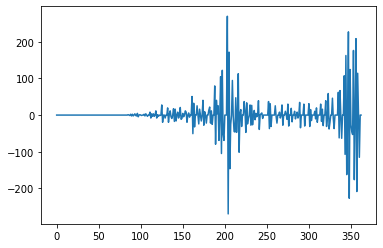

(154, 51)


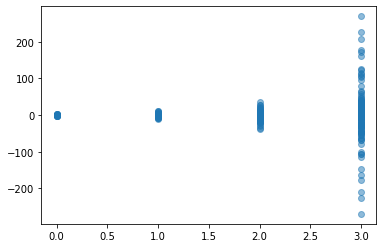

In [35]:
alameda_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'Angelina County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


## Export to csv

In [36]:
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'widespread'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'substantial'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'moderate'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'minimal'].shape)

(39259, 50)
(6491, 50)
(9886, 50)
(36566, 50)


In [37]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'TX_MarylandData_Labeled_CDCGuideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
maryland_sd_inertia.to_csv(location+filename,index=False)

TX_MarylandData_Labeled_CDCGuideline_Jan15.csv
